In [8]:
!nvidia-smi

Mon Apr 10 14:18:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:0A:00.0 Off |                    0 |
| N/A   33C    P0    46W / 163W |   3304MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Setup environment

In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Infer

In [35]:
workspace_dir = '/nfs/Workspace/CardiacSeg'

import os
import sys
from pathlib import PurePath
sys.path.append(workspace_dir)

import pandas as pd

from monai.transforms import (
   Compose,
   AddChanneld,
   EnsureChannelFirstd,
   LoadImaged,
   Orientationd,
   SqueezeDimd,
   LoadImage
)

from datasets.chgh_dataset import get_data_dicts
from data_utils.utils import get_pid_by_file
from data_utils.visualization import show_img_lbl, show_img_lbl_pred, show_img_lbl_preds, show_img_lbl_preds_overlap

from expers.infer_utils import get_tune_model_dir, get_data_path, get_pred_path

model_name = 'unetcnx_x3_2_2_a5' #'unetcnx_x3_2_2'
data_name = 'chgh'
sub_data_dir_name = 'dataset_2'
exp_name = 't_4' #'exp_2_2_x3_2_2' #'exp_2_2_x3_2_2' #'t_1' #'exp_2_2_1_x0' #'exp_2_2_x0_t6'
data_dict_file_name = 'exp_b7_9.json'#'exp_2_2.json'

root_exp_dir = os.path.join(
    workspace_dir, 
    'exps',
    'exps',
    model_name,
    data_name,
    'tune_results'
)

root_data_dir = os.path.join(
    workspace_dir, 
    'dataset',
    data_name
)

data_dir = os.path.join(root_data_dir, sub_data_dir_name)

# '/nfs/Workspace/CardiacSeg/exps/exps/unetcnx_x0/chgh/models' 
model_dir = get_tune_model_dir(root_exp_dir, exp_name)

best_checkpoint = os.path.join(model_dir, 'best_model.pth')
final_checkpoint = os.path.join(model_dir, 'final_model.pth')

infer_dir = os.path.join(
    workspace_dir, 
    'exps',
    'exps',
    model_name,
    data_name,
    'infers',
    exp_name,
)

print('\nbest model:',best_checkpoint)
print('infer dir:',infer_dir)

pid = 'pid_1000'
data_dict = get_data_path(data_dir, pid)
data_dict['pred'] = get_pred_path(root_exp_dir, exp_name, data_dict['image'])

img_pth = data_dict['image']
lbl_pth = data_dict['label'] 
print(img_pth)
print(lbl_pth)
print(data_dict['pred'])

%cd /nfs/Workspace/CardiacSeg/exps/exps/{model_name}/{data_name}

Loading results from /nfs/Workspace/CardiacSeg/exps/exps/unetcnx_x3_2_2_a5/chgh/tune_results/t_4...
2023-04-10 14:43:27,275 - No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.

Best trial 6d320_00000: 
config: {'exp': {'exp': 'exp_b7_9_x3_2_2_a5'}}
tt_dice: 0.8903141
tt_hd95: 4.954921004130534
best log dir: /nfs/Workspace/CardiacSeg/exps/exps/unetcnx_x3_2_2_a5/chgh/tune_results/t_4/main_6d320_00000_0_exp=exp_exp_b7_9_x3_2_2_a5_2023-03-29_03-54-38

best model: /nfs/Workspace/CardiacSeg/exps/exps/unetcnx_x3_2_2_a5/chgh/tune_results/t_4/main_6d320_00000_0_exp=exp_exp_b7_9_x3_2_2_a5_2023-03-29_03-54-38/models/best_model.pth
infer dir: /nfs/Workspace/CardiacSeg/exps/exps/unetcnx_x3_2_2_a5/chgh/infers/t_4
/nfs/Workspace/CardiacSeg/dataset/chgh/dataset_2/pid_1000/pid_1000.nii.gz
/nfs/Workspace/CardiacSeg/dataset/chgh/dataset_2/pid_1000/pid_1000_gt.nii.gz
/nfs/Workspace/CardiacSeg/exps/exps/unetcnx_x3_

Passing in the experiment's `trainable` will be a required argument to `Tuner.restore` starting from version 2.5. Please specify the trainable to avoid this warning.


In [42]:
import sys
# set package path
sys.path.append("/nfs/Workspace/CardiacSeg")

import os
from functools import partial

import torch

from monai.inferers import sliding_window_inference
from monai.transforms import (
    Compose,
    Orientationd,
    ToNumpyd,
    SqueezeDimd
)
from monailabel.transform.post import Restored

from data_utils.data_loader_utils import load_data_dict_json
from data_utils.dataset import get_infer_data, get_invert_infer_transform
from data_utils.io import load_json
from runners.inferer import run_infering
from networks.network import network

from expers.args import get_parser

In [37]:
args = get_parser([])
args.model_name=model_name
args.data_name=data_name
args.data_dir=data_dir
args.model_dir=model_dir
args.infer_dir=infer_dir
args.checkpoint=best_checkpoint

args.out_channels=2 
args.patch_size=4 
args.drop_rate=0.4 
args.depths=[4, 4, 8, 4] 
args.a_min = -42
args.a_max = 423
args.space_x = 0.7
args.space_y = 0.7
args.space_z = 1.0
args.roi_x = 128
args.roi_y = 128
args.roi_z = 128
args.infer_overlap = 0.25
args.sw_batch_size = 2
data_dicts = [{
    'image': img_pth,
    'label': lbl_pth
}]

In [50]:
# device
if torch.cuda.is_available():
    print("cuda is available")
    args.device = torch.device("cuda")
else:
    print("cuda is not available")
    args.device = torch.device("cpu")

# model
model = network(args.model_name, args)

# check point
if args.checkpoint is not None:
    checkpoint = torch.load(args.checkpoint, map_location="cpu")
    # load model
    model.load_state_dict(checkpoint["state_dict"])
    # load check point epoch and best acc

    print(
      "=> loaded checkpoint '{}')"\
      .format(args.checkpoint)
    )

# inferer
keys = ['pred']
post_transform = Compose([
    Orientationd(keys=keys, axcodes="LPS"),
    ToNumpyd(keys=keys),
    Restored(keys=keys, ref_image="image")
])

# post_transform = get_invert_infer_transform(data_dicts[0], args)


model_inferer = partial(
    sliding_window_inference,
    roi_size=[args.roi_x, args.roi_y, args.roi_z],
    sw_batch_size=args.sw_batch_size,
    predictor=model,
    overlap=args.infer_overlap,
)

# load infer data
data = get_infer_data(data_dicts[0], args)

cuda is available
model: unetcnx_x3_2_2_a5
[4, 4, 8, 4]
=> loaded checkpoint '/nfs/Workspace/CardiacSeg/exps/exps/unetcnx_x3_2_2_a5/chgh/tune_results/t_4/main_6d320_00000_0_exp=exp_exp_b7_9_x3_2_2_a5_2023-03-29_03-54-38/models/best_model.pth')


In [58]:
model.eval()
with torch.no_grad():
    output = model_inferer(data['image'].to('cuda'))
    output = torch.argmax(output, dim=1)
data['pred'] = output

In [52]:
# post label transform 
sqz_transform = SqueezeDimd(keys=['label'])
data = sqz_transform(data)

# post transform
data = post_transform(data)

In [53]:
ori_data = LoadImaged(keys=['image', 'label'])(data_dicts[0])

In [ ]:
from data_utils.visualization import show_img_lbl

In [61]:
data['pred'].shape

torch.Size([1, 270, 270, 143])

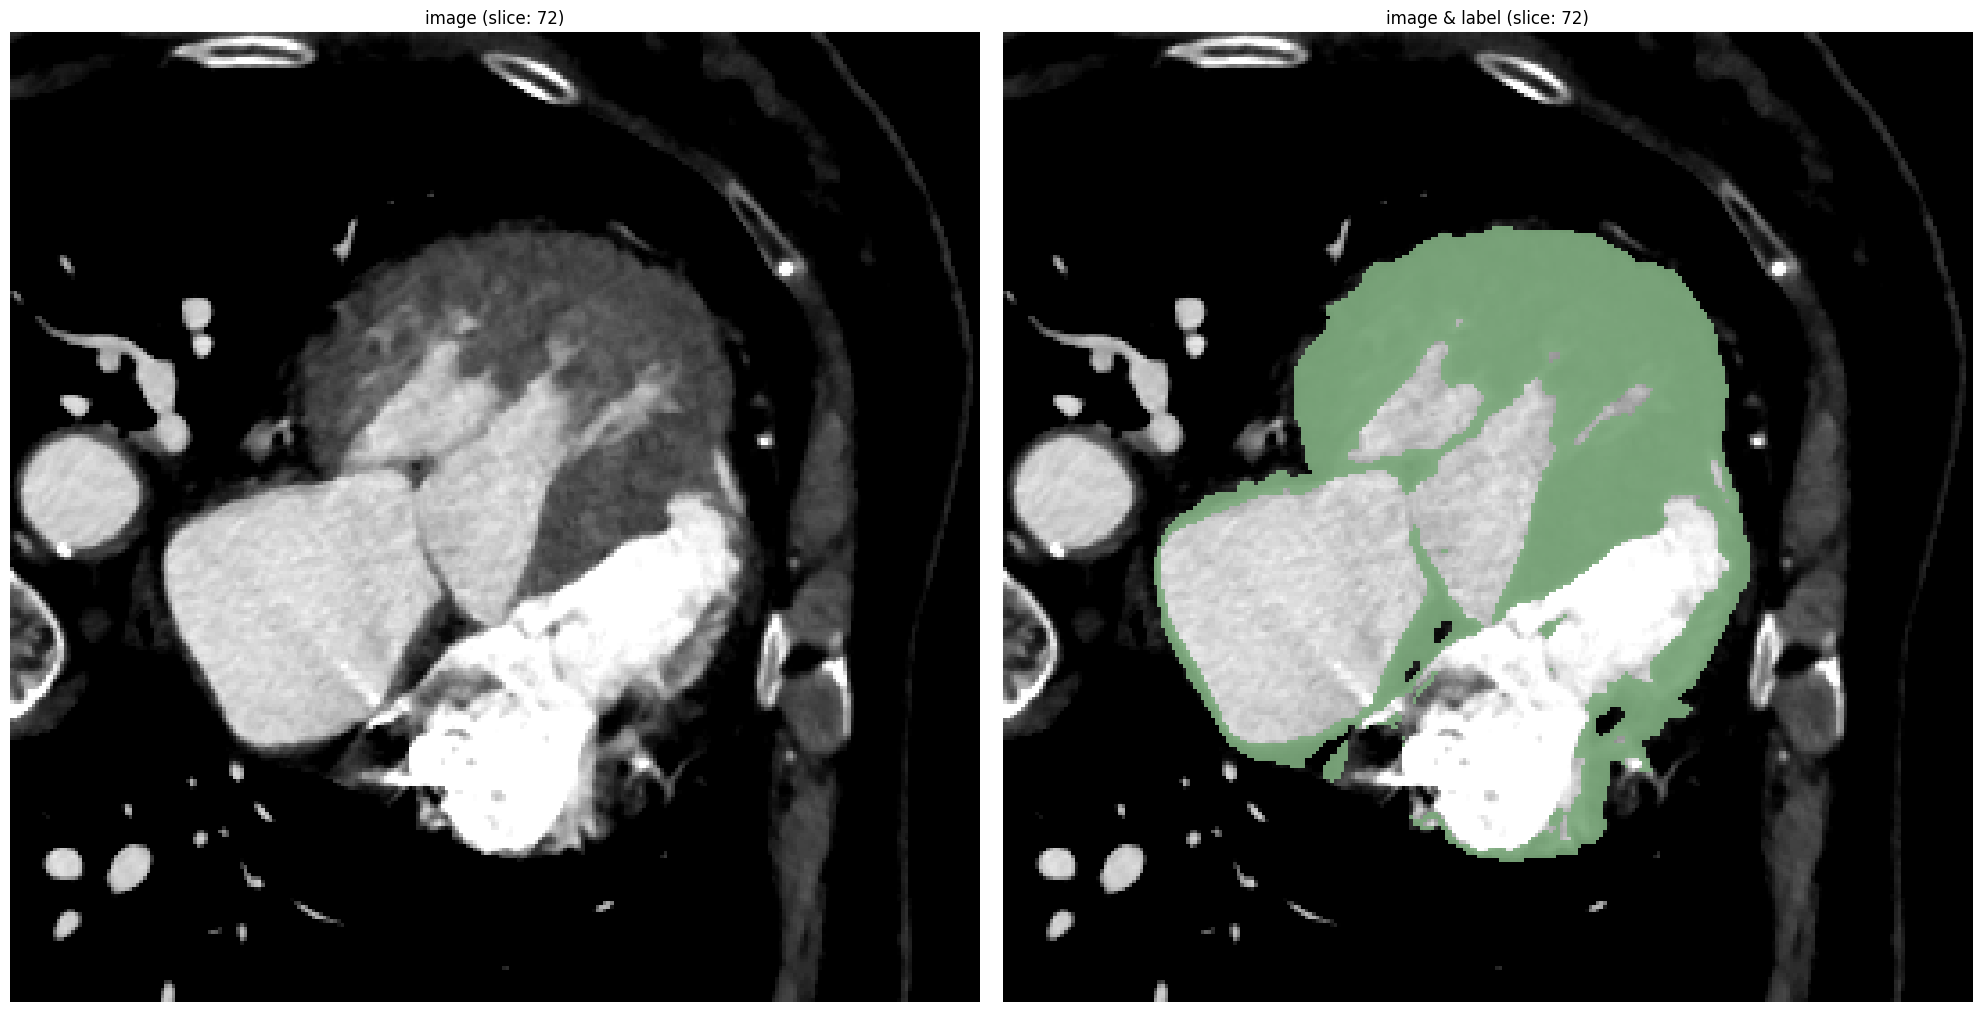

In [67]:
slice_idx = 72
show_img_lbl(data['image'][0, 0, :,:,slice_idx], data['pred'][0, :,:,slice_idx].cpu().numpy(), slice_idx, num_classes=2)

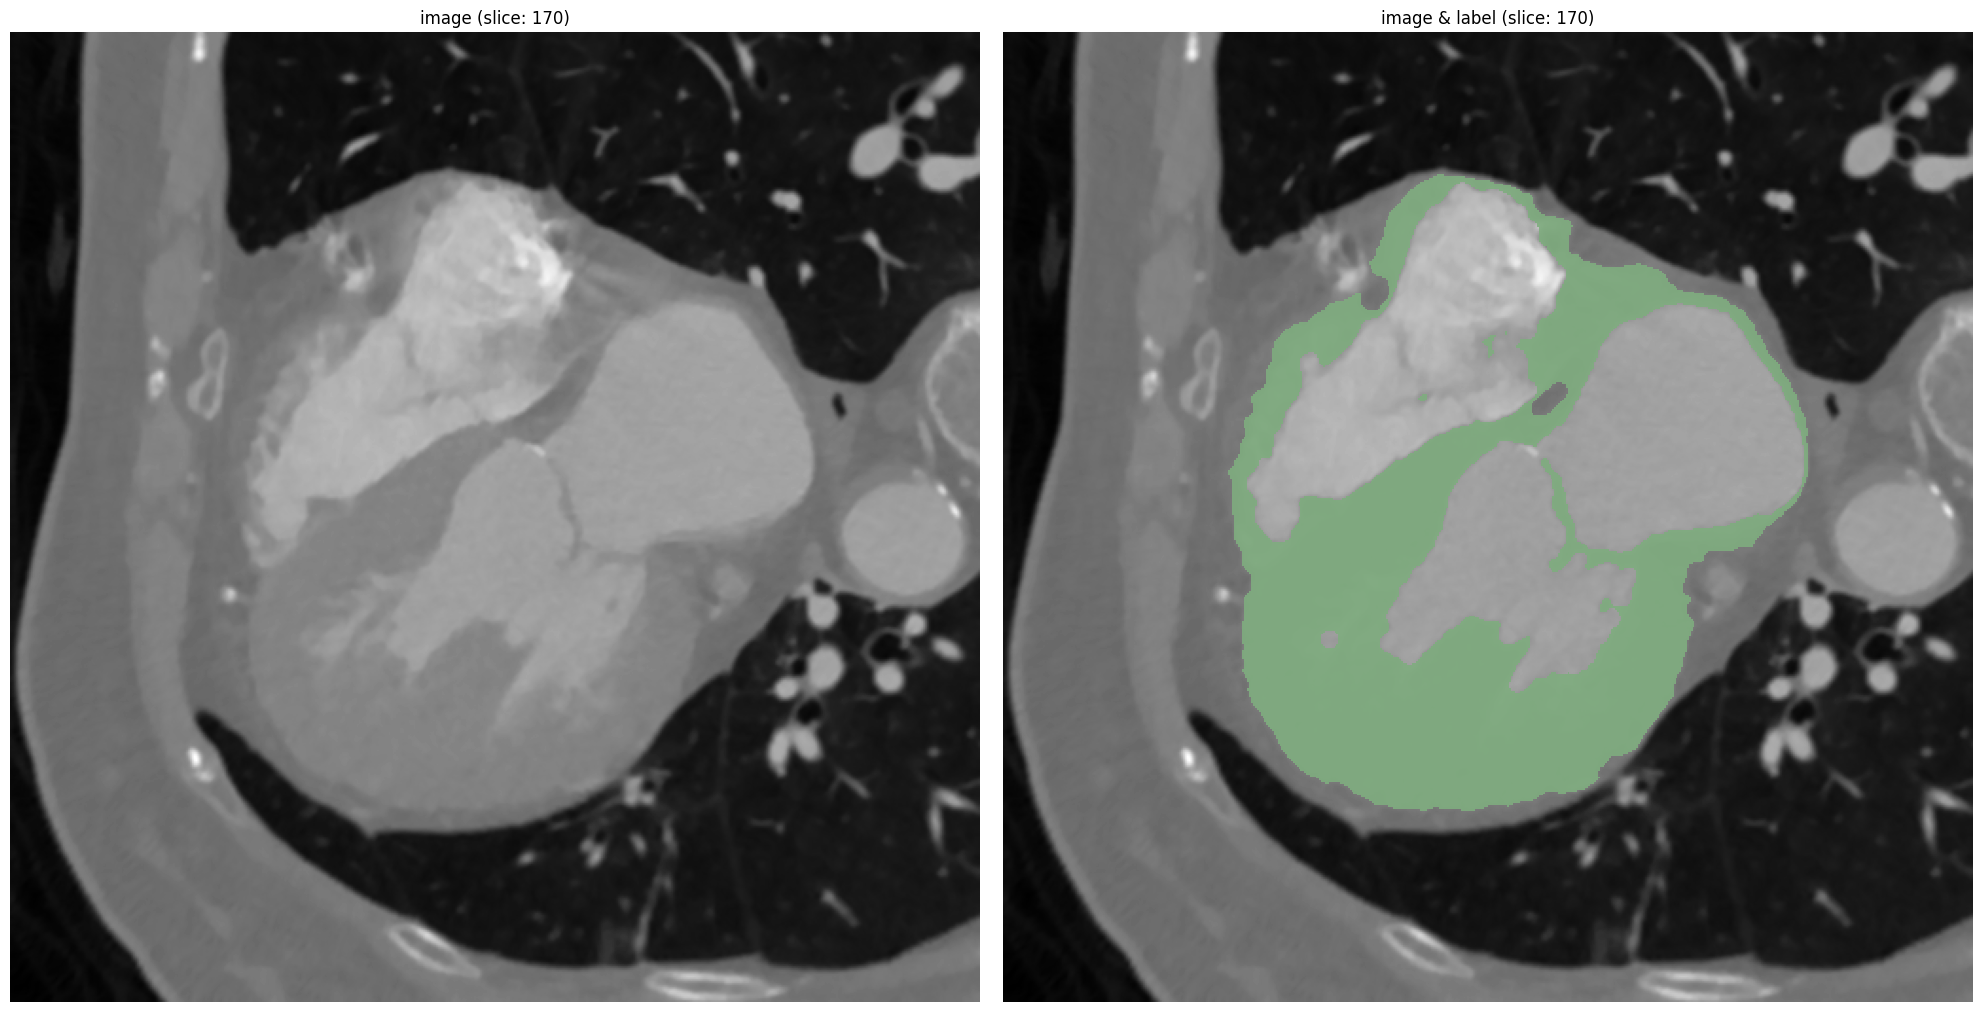

In [57]:
slice_idx = 170
show_img_lbl(ori_data['image'][:,:,slice_idx], ori_data['label'][:,:,slice_idx], slice_idx, num_classes=2)

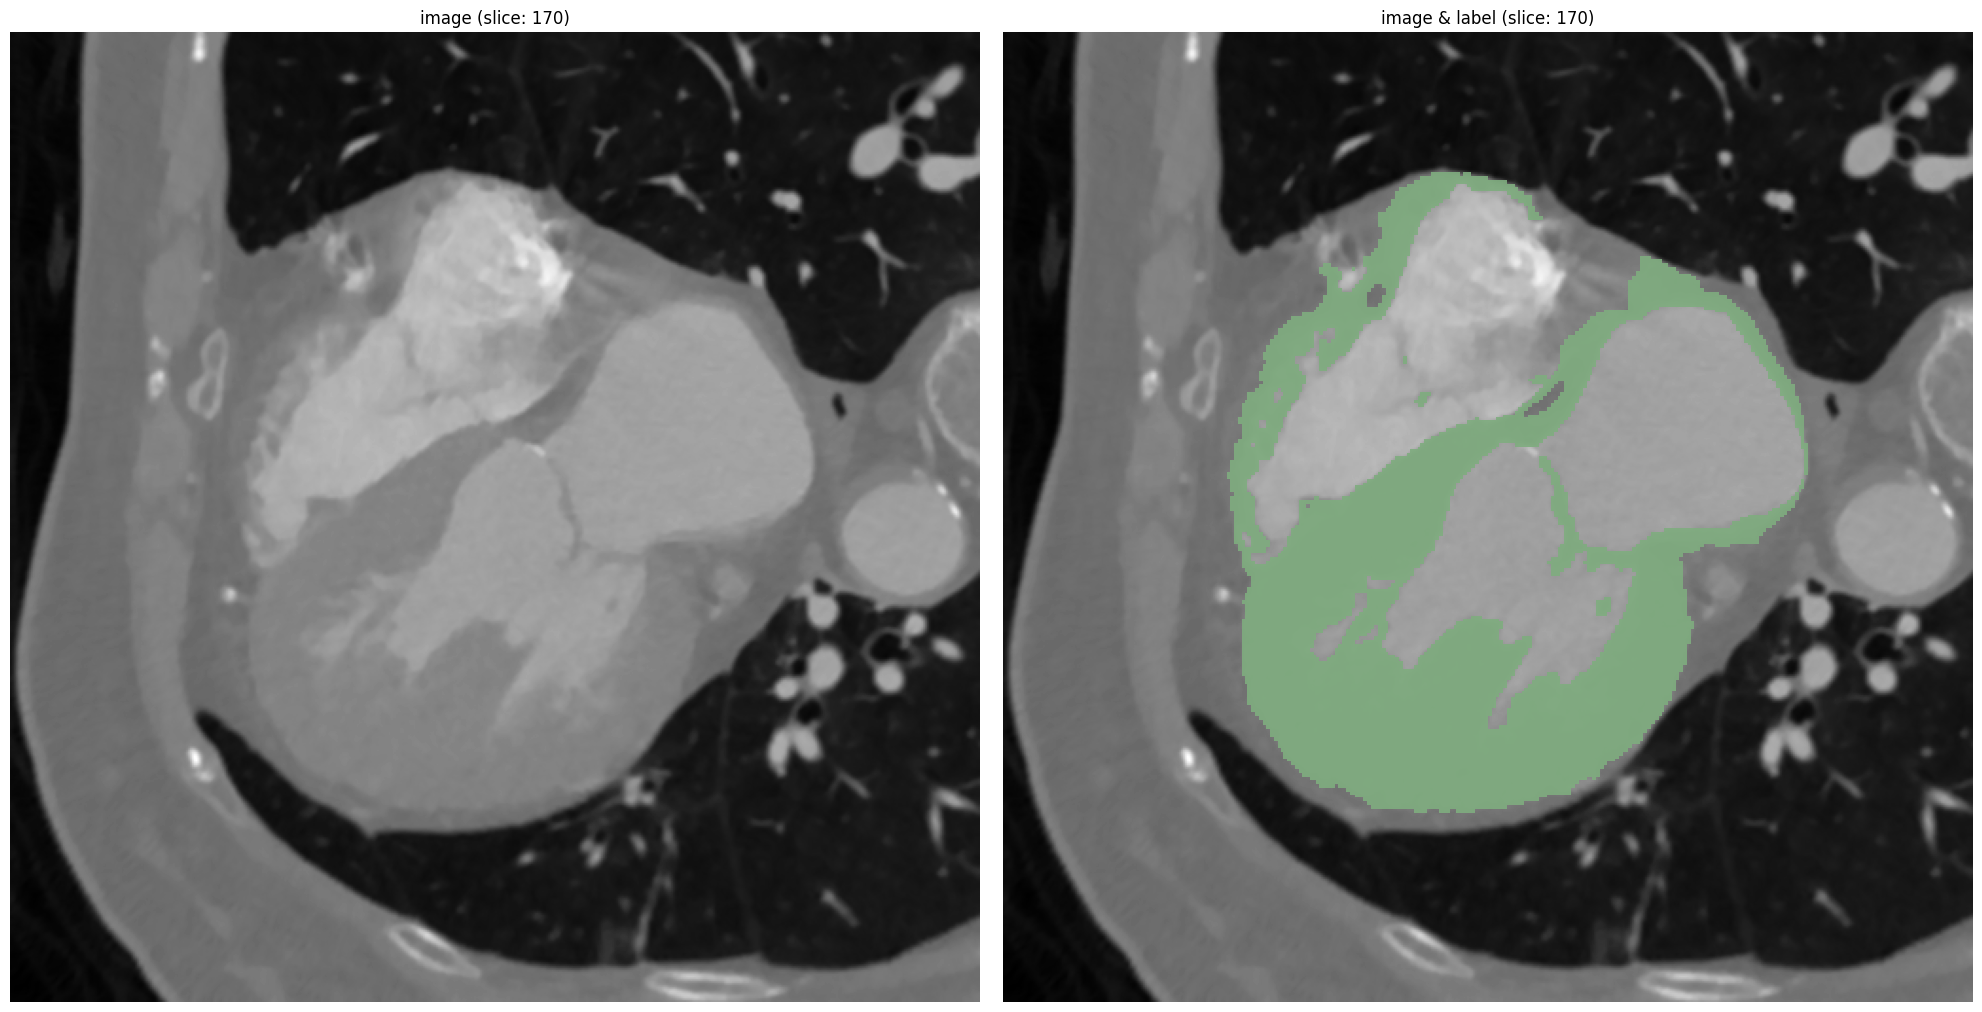

In [55]:
slice_idx = 170
show_img_lbl(ori_data['image'][:,:,slice_idx], data['pred'][:,:,slice_idx], slice_idx, num_classes=2)